# Geosmin Data Analysis

In this notebook we want to solve the following problem:

The geosmin data is divided into two parts. The first contains the concentration of geosmin in the reservoir and the second contains the same data but in each treatament station. There are two treatment stations: VETA (Velha Estação de Tratamento de Água) e NETA (Nova Estação de Tratamento de Água).

We don't know, however, how much water goes through each treatment stations, but we do have the following historical data:
* Prior to 18/3/2020: concentration before treatment, concentration after treatment
* After 23/10/2020: concentration before treatment, concentration after treatment in VETA, concentration after treatment in NETA

We then modeled this problem as a chemistry problem. Were you good at solutions and concentration of mixtures? Well, this is no different than that. We have a concentration of geosmin in the water and we know that by mixing liquids of a certain concentration each we get an intermediate concentration. The problem is that we don't know how much problem from each liquid we've poured.

Let's first look at the water treatment station like a black box that takes water and ejects (a cleaner) water.

```
Capture point --> Water treatment stations (Env) --> Reservoir
(pc, Vc)                                             (pr, Vr)

Legend:
p = concentration
V = volume
E = efficiency
```

We define efficiency as the ratio between the concentration after and before the treatment (`Env=pr/pc`). It is thus a number between 0 and 1 (because we assume that we don't add any impurities to the water, so `pr < pc`).

Now, let's look at the each water treatment plant individually.

```
Capture point -+--> NETA (En) --(pn, Vn)--+--> Reservoir
(pc, Vc)       |                          |    (pr, Vr)
               +--> VETA (Ev) --(pv, Vv)--+
```

Notice that the endpoints haven't changed. We just inspect the water treatment station in more detail. We learned that there are actually two water treatment stations inside. Each one has its own efficiency (`En` and `Ev`). We define `En = pn/pc`, `Ev = pv/pc`, `Vn+Vv=Vr=Vc`.

We can calculate the efficiencies of NETA, VETA and the average of the two by historic data analysis. It is simply done by dividing the concentration of geosmin after treatment by the concentration before treatment (capture point).

We also assume that geosmin isn't lost between the treatment exit and the reservoir. If `m` is mass of geosmin, then `mn+mv=mr`. We know that `p=m/V`, so `m=pV`. By this we obtain `pn*Vn+pv*Vv=pr*Vr`.

We also define `Un=Vn/Vr` and `Uv=Vv/Vr` which are the percentage of how much water from the reservoir belongs to each water treatment. You can clearly see that `Un+Uv=1`. We now solve this system of equations to obtain `Un` and `Uv`, which will allow us to go from the mean and individual values, and backwards.

```
pn*Vn+pv*Vv=pr*Vr (divide by Vr)
pn*Un+pv*Uv=pr (divide by pc)
En*Un+Ev*Uv=Env (Uv=1-Un)
En*Un+Ev*(1-Un)=Env
En*Un+Ev-Ev*Un=Env
Un*(En-Ev)=Env-Ev

     Env-Ev               Env-En
Un = ------    ==>  Uv =  ------
     En-Ev                Ev-En
```

We need to obtain then `Env`, `En` and `Ev` from historical data. We also need to take into account the "population" of samples, because the ratio varies from time to time. We would also like to plot the histogram of each of these populations.

When doing ratios between these concentrations, we need also to take care about upper bounds. If one of the data (numerator or denominator) is uncertain, we don't calculate the ratio.

Let's first get `Env` from data prior to 18/03/2020.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
csv_dir = os.path.join('output', 'guandu')
dataset = {}

In [3]:
# Read CSV with data (with MEAN concentration and capture)
df1 = pd.read_csv(os.path.join(csv_dir, 'geosmin_2020-01-26_2020-03-18.csv'))

In [4]:
# Filter columns with uncertain data
df1 = df1[(df1.is_capture_ub == False) & (df1.is_etas_ub == False)]

In [5]:
# Calculate efficiency
Env = df1.etas / df1.capture

In [6]:
# Remove outliers
Env = Env[Env < 1]

In [7]:
import matplotlib.pyplot as plt

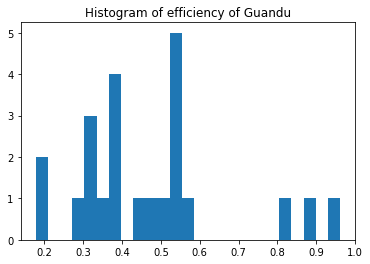

In [8]:
# Plot efficiency of Guandu
plt.hist(Env, bins=25)
plt.title("Histogram of efficiency of Guandu")
plt.show()

Now let's obtain `Ev` and `En` from data after 23/10/2020.

In [9]:
# Read CSV with data (with concentration on VETA and NETA, and capture)
df2 = pd.read_csv(os.path.join(csv_dir, 'geosmin_2020-10-23_today.csv'))

In [10]:
# Filter columns with uncertain data
# We restrict per ETA, because then we have more data ;-)
df3 = df2[(df2.is_capture_ub == False) & (df2.is_veta_ub == False)]
df4 = df2[(df2.is_capture_ub == False) & (df2.is_neta_ub == False)]

In [11]:
# Calculate efficiencies
Ev = df3.veta / df3.capture
En = df4.neta / df4.capture

In [12]:
# Remove outliers
Ev = Ev[Ev <= 1]
En = En[En <= 1]

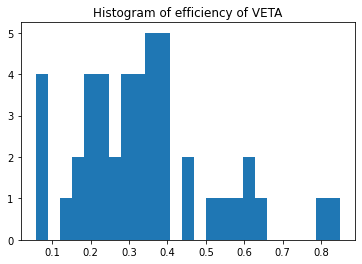

In [13]:
# Plot histogram of efficiencie of VETA
# Plot efficiency of Guandu
plt.hist(Ev, bins=25)
plt.title("Histogram of efficiency of VETA")
plt.show()

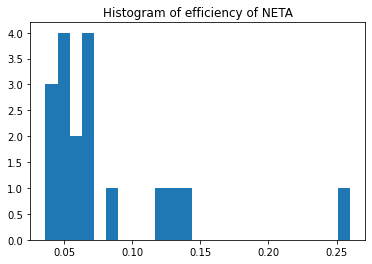

In [14]:
# Plot histogram of efficiencie of NETA
# Plot efficiency of Guandu
plt.hist(En, bins=25)
plt.title("Histogram of efficiency of NETA")
plt.show()

We can clearly see that NETA is more efficient than VETA. Let's calculate the average efficiencies.

In [15]:
print("mean(Env) = {:.2f}%".format(100*np.mean(Env)))
print("mean(Ev) = {:.2f}%".format(100*np.mean(Ev)))
print("mean(En) = {:.2f}%".format(100*np.mean(En)))

mean(Env) = 47.44%
mean(Ev) = 33.91%
mean(En) = 8.07%


Here we see that mean(Env) > mean(Ev) > mean(En). We expected mean(Env) to be between mean(Ev) and mean(En), but it is not. This may be due to the fact that in the period of approximately 7 months, the quality of NETA and VETA has greatly improved. If we had data from these two measurements (the mean efficiency and the efficiency of each ETA), the data would be much more reliable.